## Anaylsis Tiles

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed
from typing import List, Set, Dict, Any

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box, from_file
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import minimize
from sklearn.metrics import jaccard_score
import cv2
import seaborn as sns

In [4]:
class CFG(object):
    # basic
    debug: bool = False
    debug_sample: int = 64
    folds: int  = 4
    seed: int   = 417
    eps: float  = 1e-12
    
    # data
    PATH_CSV: str  =  f'../data/002_Full+California/012_seed417.csv'
    PATH_DATA = '../data/002_Full+California/'
    
    percentiles = [1, 99]
    
    outdir = 'output/analysis/'
    
# box
cfg = Box({k:v for k, v in dict(vars(CFG)).items() if '__' not in k})
    
# 乱数のシードを設定
np.random.seed(cfg.seed)
random.seed(cfg.seed)
    
pprint(cfg)

{'PATH_CSV': '../data/002_Full+California/012_seed417.csv',
 'PATH_DATA': '../data/002_Full+California/',
 'debug': False,
 'debug_sample': 64,
 'eps': 1e-12,
 'folds': 4,
 'outdir': 'output/analysis/',
 'percentiles': BoxList([1, 99]),
 'seed': 417}


In [5]:
df = pd.read_csv(cfg.PATH_CSV)
df.sample(4)

name   
371   d38ad371-6c7b-4780-8f9f-e503d784f2ed_108  \
1960    fde53a49-77c7-48de-85cc-d4633c5c705b_1   
452    d38ad371-6c7b-4780-8f9f-e503d784f2ed_75   
1767    a253b245-bb18-4657-8797-6809b754bf52_0   

                                                feature   
371   ../data/002_Full+California/img/d38ad371-6c7b-...  \
1960  ../data/002_Full+California/img/fde53a49-77c7-...   
452   ../data/002_Full+California/img/d38ad371-6c7b-...   
1767  ../data/002_Full+California/img/a253b245-bb18-...   

                                                   mask  defects  fold  hight   
371   ../data/002_Full+California/ann/d38ad371-6c7b-...    False    -1    512  \
1960  ../data/002_Full+California/ann/fde53a49-77c7-...     True     0    512   
452   ../data/002_Full+California/ann/d38ad371-6c7b-...    False    -1    512   
1767  ../data/002_Full+California/ann/a253b245-bb18-...    False     1    512   

      width  california  pre_missing  post_missing     ratio  cv  
371     512        True        False         False  0.000000   0  
1960    512       False         True         False  0.029827   0  
452     512        True        False         False  0.000000   0  
1767    512       False        False         False  0.002846   0

## Test Visualize

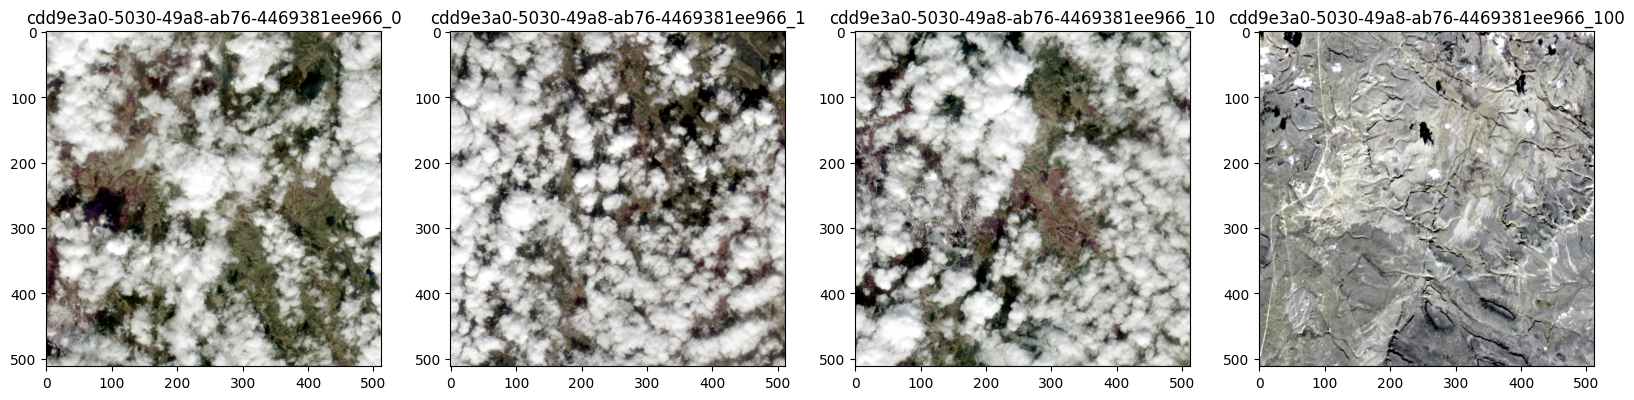

In [6]:
NUM_SAMPLE = 4
df_sample = df.head(NUM_SAMPLE)

plt.figure(figsize=(20, 20), facecolor='white')
for it, (idx, row) in enumerate(df_sample.iterrows()):
    img = np.load(row.feature)

    true_color = np.log(img[:, :, 2:5] + 1)

    for ch in range(3):
        im = true_color[:, :, ch]
        top, bottom = np.percentile(im, max(cfg.percentiles)), np.percentile(im, min(cfg.percentiles))
        im = np.clip(true_color[:, :, ch], a_min=bottom, a_max=top)
        true_color[:, :, ch] = (im - bottom) / (top - bottom)
        
    true_color = (true_color * 255).astype(np.uint8)[:,:, ::-1]
    
    plt.subplot(4, 4, it+1)
    plt.title(row['name'])
    plt.imshow(true_color)
    
    # plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, f'011_true-color_tiles.png'))
plt.show();

## Tile View

In [14]:
TARGET_SCENE = 'cdd9e3a0-5030-49a8-ab76-4469381ee966'

df['scene_id'] = df['name'].apply(lambda x: os.path.basename(x).split('_')[0])
df['tile_id'] = df['name'].apply(lambda x: int(os.path.basename(x).split('_')[1]))

df.sort_values(by=["scene_id", "tile_id"], ascending=[False, True], inplace=True)

df_scene = df[df['scene_id'] == TARGET_SCENE]
df_scene.head(3)

name   
0     cdd9e3a0-5030-49a8-ab76-4469381ee966_0  \
1862  cdd9e3a0-5030-49a8-ab76-4469381ee966_0   
1     cdd9e3a0-5030-49a8-ab76-4469381ee966_1   

                                                feature   
0     ../data/002_Full+California/img/cdd9e3a0-5030-...  \
1862  ../data/002_Full+California/img/cdd9e3a0-5030-...   
1     ../data/002_Full+California/img/cdd9e3a0-5030-...   

                                                   mask  defects  fold  hight   
0     ../data/002_Full+California/ann/cdd9e3a0-5030-...    False    -1    512  \
1862  ../data/002_Full+California/ann/cdd9e3a0-5030-...    False     3    512   
1     ../data/002_Full+California/ann/cdd9e3a0-5030-...    False    -1    512   

      width  california  pre_missing  post_missing     ratio  cv   
0       512        True        False         False  0.000000   0  \
1862    512       False        False         False  0.007072   2   
1       512        True        False         False  0.000000   3   

                                  scene_id  tile_id  
0     cdd9e3a0-5030-49a8-ab76-4469381ee966        0  
1862  cdd9e3a0-5030-49a8-ab76-4469381ee966        0  
1     cdd9e3a0-5030-49a8-ab76-4469381ee966        1

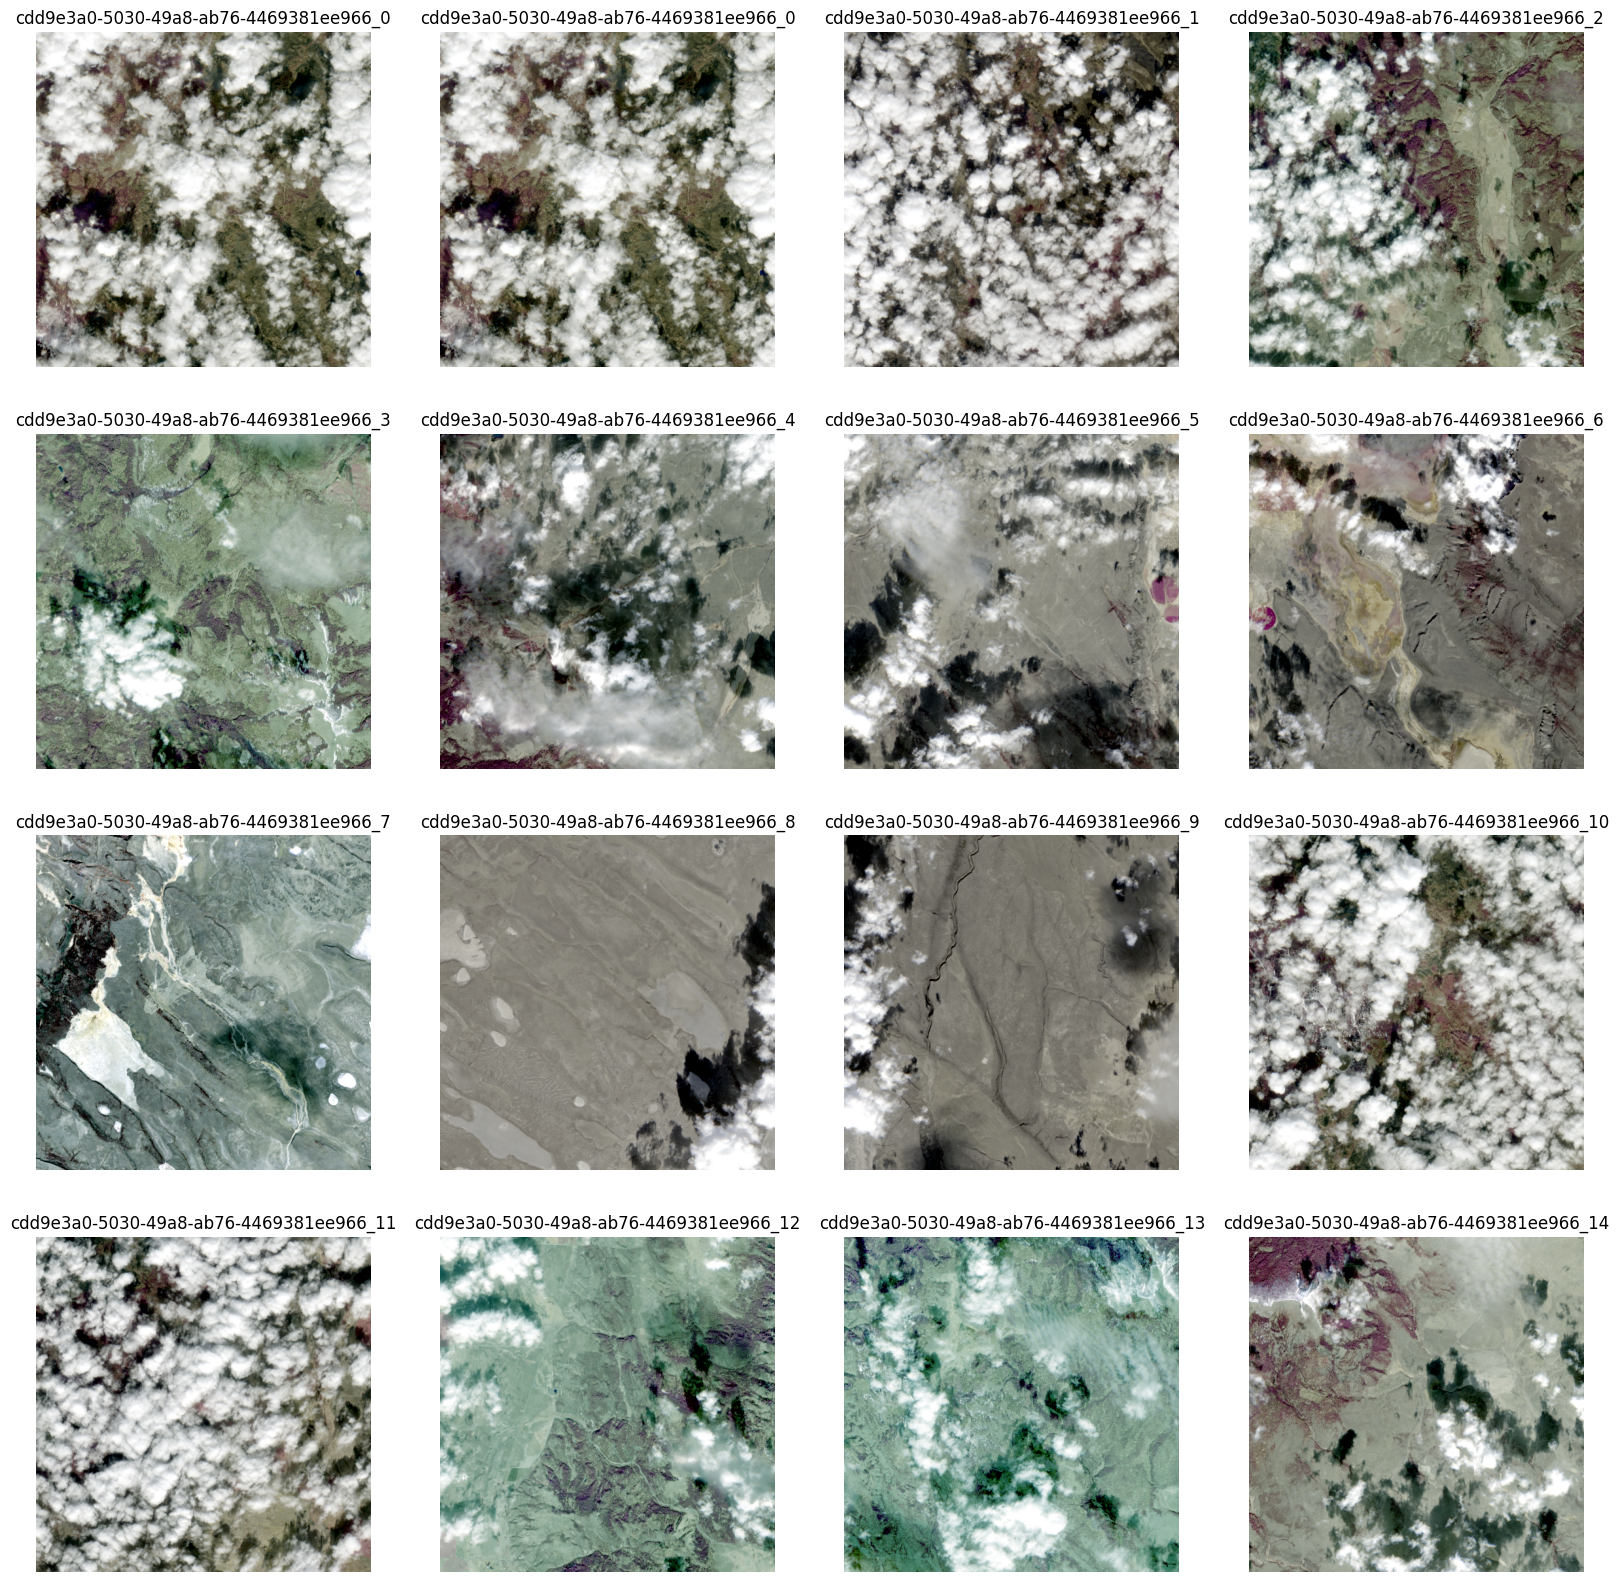

In [16]:
NUM_SAMPLE = 16
df_sample = df_scene.head(NUM_SAMPLE)

plt.figure(figsize=(20, 20), facecolor='white')
for it, (idx, row) in enumerate(df_sample.iterrows()):
    img = np.load(row.feature)

    true_color = np.log(img[:, :, 2:5] + 1)

    for ch in range(3):
        im = true_color[:, :, ch]
        top, bottom = np.percentile(im, max(cfg.percentiles)), np.percentile(im, min(cfg.percentiles))
        im = np.clip(true_color[:, :, ch], a_min=bottom, a_max=top)
        true_color[:, :, ch] = (im - bottom) / (top - bottom)
        
    true_color = (true_color * 255).astype(np.uint8)[:,:, ::-1]
    
    plt.subplot(4, 4, it+1)
    plt.title(row['name'])
    plt.imshow(true_color)
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, f'014_true-color_tiles_{TARGET_SCENE}.png'))
plt.show();

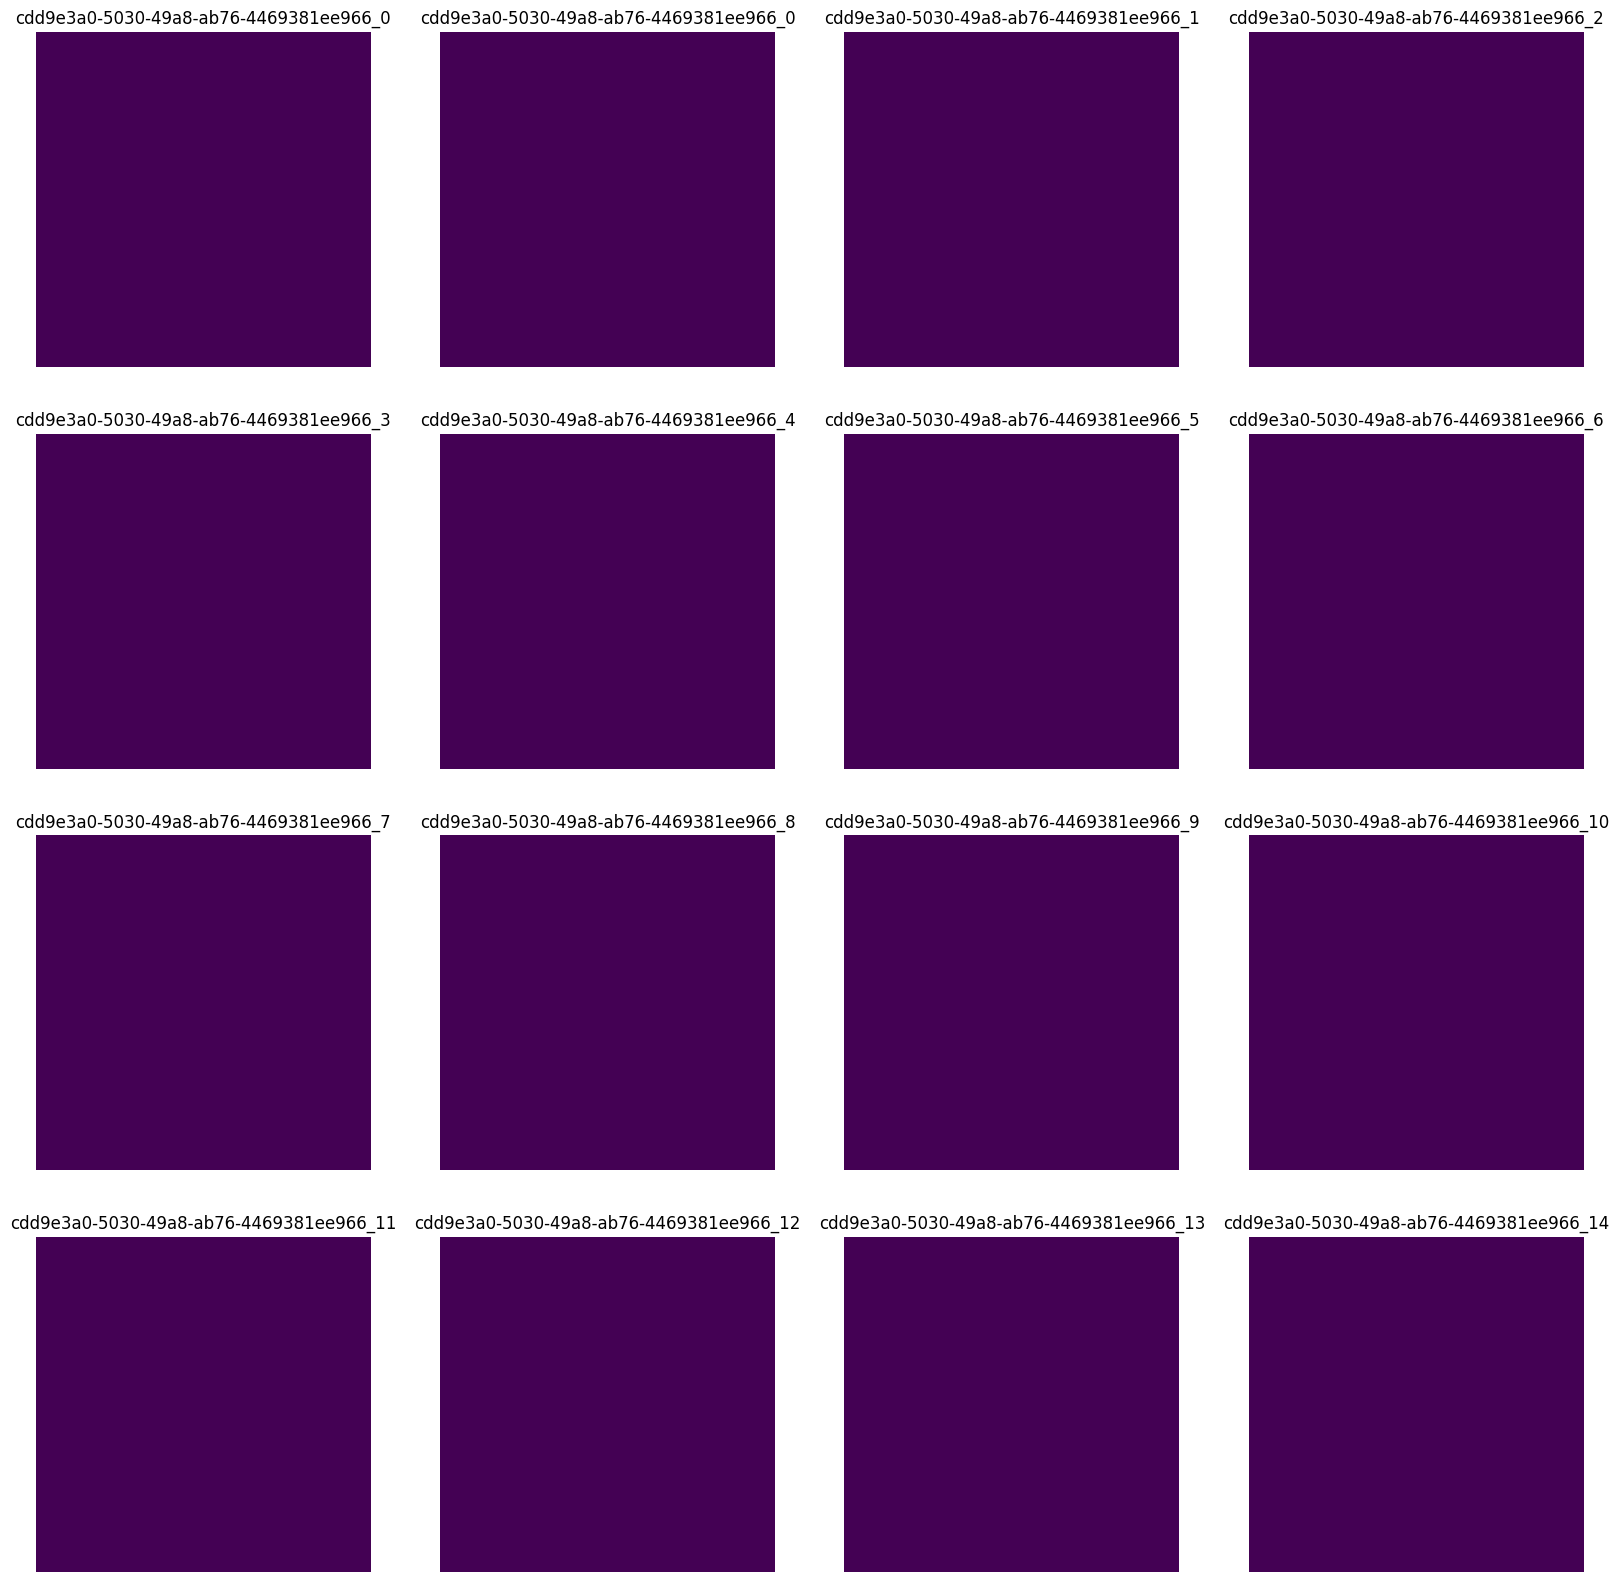

In [18]:
NUM_SAMPLE = 16
df_sample = df_scene.head(NUM_SAMPLE)

plt.figure(figsize=(20, 20), facecolor='white')
for it, (idx, row) in enumerate(df_sample.iterrows()):
    mask = np.load(row['mask'])
    
    plt.subplot(4, 4, it+1)
    plt.title(row['name'])
    plt.imshow(mask)
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, f'014_mask_tiles_{TARGET_SCENE}.png'))
plt.show();

## Tile Mask Check

In [30]:
TARGET_SCENE = '03790d1a-5b9c-48ed-820d-83abbe656035'

df_pos = df[df['ratio'] > 0.]
df_pos['scene_id'] = df_pos['name'].apply(lambda x: os.path.basename(x).split('_')[0])
df_pos['tile_id'] = df_pos['name'].apply(lambda x: int(os.path.basename(x).split('_')[1]))
display(df_pos)

df_pos.sort_values(by=["scene_id", "tile_id"], ascending=[False, True], inplace=True)

df_scene = df_pos[df_pos['scene_id'] == TARGET_SCENE]
df_scene.head(3)

/tmp/ipykernel_4497/2001323994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['scene_id'] = df_pos['name'].apply(lambda x: os.path.basename(x).split('_')[0])
/tmp/ipykernel_4497/2001323994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['tile_id'] = df_pos['name'].apply(lambda x: int(os.path.basename(x).split('_')[1]))


name   
1964  fed23a7b-a147-46e4-b109-881ef770fd5d_0  \
1963  feb08801-64b1-4d11-a3fc-0efaad1f4274_0   
1961  fe3eec1e-2204-4cde-a2ef-56be8b5effca_0   
1962  fe3eec1e-2204-4cde-a2ef-56be8b5effca_1   
1959  fde53a49-77c7-48de-85cc-d4633c5c705b_0   
...                                      ...   
1434  03790d1a-5b9c-48ed-820d-83abbe656035_0   
1435  03790d1a-5b9c-48ed-820d-83abbe656035_1   
1432  0328d12a-4ad8-4504-8ac5-70089db10b4e_0   
1433  0328d12a-4ad8-4504-8ac5-70089db10b4e_1   
1431  012b8863-976c-44e1-a491-9adf19c1cbba_0   

                                                feature   
1964  ../data/002_Full+California/img/fed23a7b-a147-...  \
1963  ../data/002_Full+California/img/feb08801-64b1-...   
1961  ../data/002_Full+California/img/fe3eec1e-2204-...   
1962  ../data/002_Full+California/img/fe3eec1e-2204-...   
1959  ../data/002_Full+California/img/fde53a49-77c7-...   
...                                                 ...   
1434  ../data/002_Full+California/img/03790d1a-5b9c-...   
1435  ../data/002_Full+California/img/03790d1a-5b9c-...   
1432  ../data/002_Full+California/img/0328d12a-4ad8-...   
1433  ../data/002_Full+California/img/0328d12a-4ad8-...   
1431  ../data/002_Full+California/img/012b8863-976c-...   

                                                   mask  defects  fold  hight   
1964  ../data/002_Full+California/ann/fed23a7b-a147-...     True     3    512  \
1963  ../data/002_Full+California/ann/feb08801-64b1-...    False     4    512   
1961  ../data/002_Full+California/ann/fe3eec1e-2204-...    False     1    512   
1962  ../data/002_Full+California/ann/fe3eec1e-2204-...    False     1    512   
1959  ../data/002_Full+California/ann/fde53a49-77c7-...     True     0    512   
...                                                 ...      ...   ...    ...   
1434  ../data/002_Full+California/ann/03790d1a-5b9c-...    False     3    512   
1435  ../data/002_Full+California/ann/03790d1a-5b9c-...    False     3    512   
1432  ../data/002_Full+California/ann/0328d12a-4ad8-...    False     4    512   
1433  ../data/002_Full+California/ann/0328d12a-4ad8-...    False     4    512   
1431  ../data/002_Full+California/ann/012b8863-976c-...    False     1    512   

      width  california  pre_missing  post_missing     ratio  cv   
1964    512       False         True         False  0.004906   1  \
1963    512       False        False         False  0.005775   1   
1961    512       False        False         False  0.008720   1   
1962    512       False        False         False  0.000107   2   
1959    512       False         True         False  0.058334   1   
...     ...         ...          ...           ...       ...  ..   
1434    512       False        False         False  0.001194   3   
1435    512       False        False         False  0.004578   0   
1432    512       False        False         False  0.004162   3   
1433    512       False        False         False  0.001308   0   
1431    512       False        False         False  0.029289   2   

                                  scene_id  tile_id  
1964  fed23a7b-a147-46e4-b109-881ef770fd5d        0  
1963  feb08801-64b1-4d11-a3fc-0efaad1f4274        0  
1961  fe3eec1e-2204-4cde-a2ef-56be8b5effca        0  
1962  fe3eec1e-2204-4cde-a2ef-56be8b5effca        1  
1959  fde53a49-77c7-48de-85cc-d4633c5c705b        0  
...                                    ...      ...  
1434  03790d1a-5b9c-48ed-820d-83abbe656035        0  
1435  03790d1a-5b9c-48ed-820d-83abbe656035        1  
1432  0328d12a-4ad8-4504-8ac5-70089db10b4e        0  
1433  0328d12a-4ad8-4504-8ac5-70089db10b4e        1  
1431  012b8863-976c-44e1-a491-9adf19c1cbba        0  

[534 rows x 14 columns]

/tmp/ipykernel_4497/2001323994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos.sort_values(by=["scene_id", "tile_id"], ascending=[False, True], inplace=True)


name   
1434  03790d1a-5b9c-48ed-820d-83abbe656035_0  \
1435  03790d1a-5b9c-48ed-820d-83abbe656035_1   

                                                feature   
1434  ../data/002_Full+California/img/03790d1a-5b9c-...  \
1435  ../data/002_Full+California/img/03790d1a-5b9c-...   

                                                   mask  defects  fold  hight   
1434  ../data/002_Full+California/ann/03790d1a-5b9c-...    False     3    512  \
1435  ../data/002_Full+California/ann/03790d1a-5b9c-...    False     3    512   

      width  california  pre_missing  post_missing     ratio  cv   
1434    512       False        False         False  0.001194   3  \
1435    512       False        False         False  0.004578   0   

                                  scene_id  tile_id  
1434  03790d1a-5b9c-48ed-820d-83abbe656035        0  
1435  03790d1a-5b9c-48ed-820d-83abbe656035        1

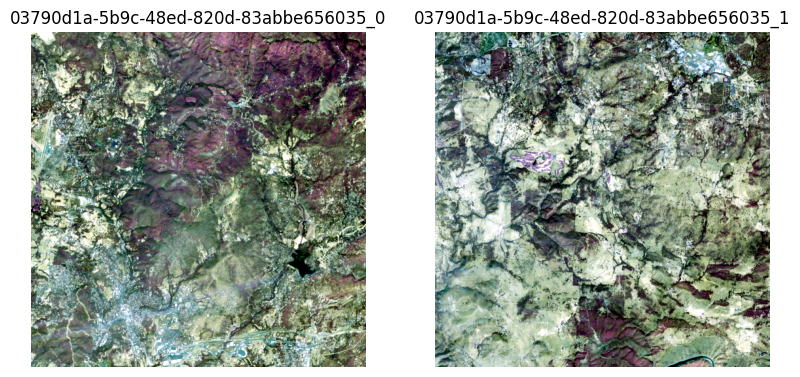

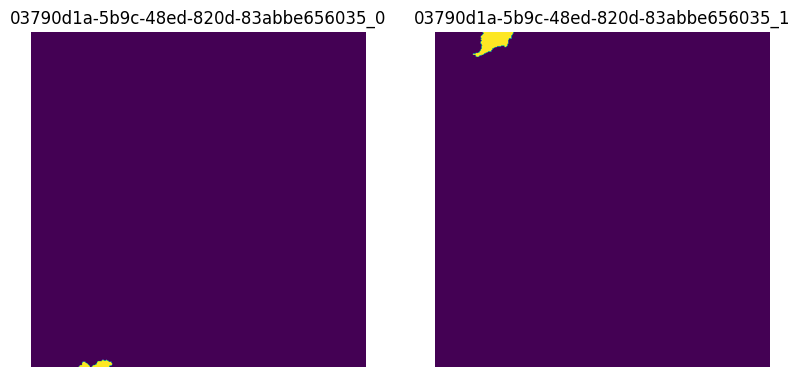

In [31]:
NUM_SAMPLE = 16
NUM_START = 0

df_sample = df_scene[NUM_START: NUM_START + NUM_SAMPLE]

plt.figure(figsize=(20, 20), facecolor='white')
for it, (idx, row) in enumerate(df_sample.iterrows()):
    img = np.load(row.feature)

    true_color = np.log(img[:, :, 2:5] + 1)

    for ch in range(3):
        im = true_color[:, :, ch]
        top, bottom = np.percentile(im, max(cfg.percentiles)), np.percentile(im, min(cfg.percentiles))
        im = np.clip(true_color[:, :, ch], a_min=bottom, a_max=top)
        true_color[:, :, ch] = (im - bottom) / (top - bottom)
        
    true_color = (true_color * 255).astype(np.uint8)[:,:, ::-1]
    
    plt.subplot(4, 4, it+1)
    plt.title(row['name'])
    plt.imshow(true_color)
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 
    f'014_true-color_tiles_{TARGET_SCENE}_start{NUM_START}-{NUM_SAMPLE}.png'))
plt.show();

plt.figure(figsize=(20, 20), facecolor='white')
for it, (idx, row) in enumerate(df_sample.iterrows()):
    mask = np.load(row['mask'])
    plt.subplot(4, 4, it+1)
    plt.title(row['name'])
    plt.imshow(mask)
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 
    f'014_mask_tiles_{TARGET_SCENE}_start{NUM_START}-{NUM_SAMPLE}.png'))
plt.show();

plt.clf()
plt.close('all')